In [1]:
import nltk
import pandas as pd
import numpy as np
import os
import majka
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from tabletext import to_text

from parser import parse_xml_file
from stop_words import get_stop_words
from string_helper import replace_string_with_pattern, clear_empty_string, decode_html_chars

In [2]:
# Configuration
DEBUG = False

if (DEBUG):
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.width', 1000)

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Stopwords
stop_words = get_stop_words('cz')
# Extended with custom (those are missing from official stop_words package)
stop_words.extend(['a','v','vo','na','k','u','i','zo','z','so','s',])

# Czech lemmatizer Majka
morph = majka.Majka('../wordlists/majka.w-lt')
morph.flags |= majka.ADD_DIACRITICS  # Find word forms with diacritics
morph.flags |= majka.DISALLOW_LOWERCASE  # Do not enable to find lowercase variants
morph.flags |= majka.IGNORE_CASE  # Ignore the word case whatsoever
morph.flags = 0  # Unset all flags
morph.tags = False  # Return just the lemma
morph.first_only = True  # Return only the first entry

# Histogram of unlemmatizable words
unlemmatizable_tokens_histogram = {}
# Treshold of occurrences of unlemmatizable tokens, below which the tokens won't be added to the result
unlemmatizable_tokens_threshold = 2

In [3]:
# Load file paths
xml_file_path = '../data/test.xml' if DEBUG else '../data/cswiki-latest-pages-articles.xml'
parsed_file_path = '../data/out-parsed.csv'
tokenized_file_path = '../data/out-tokenized.csv'
lemmatized_file_path = '../data/out-lemmatized.csv'

In [4]:
# Remove files if exists (because we'll append to them)
for filePath in [parsed_file_path,tokenized_file_path,lemmatized_file_path]:
    if os.path.exists(filePath):
        os.remove(filePath)

# Parsing, Stemming and Lemmatizing

In [5]:
# Parse input file line by line 
parse_xml_file(xml_file_path, parsed_file_path)

In [6]:
def clear_data(dataframe):
    for col in dataframe:
        dataframe[col] = dataframe[col]\
        .apply(lambda x: x if x is not np.NaN else None) \
        .apply(replace_string_with_pattern,pattern=r"[\\/:.,\-_#()?“„ ]+|{.*}",replace_with=' ') \
        .apply(replace_string_with_pattern,pattern=r"&amp;",replace_with='&') \
        .apply(decode_html_chars) \
        .apply(lambda x: str(x) if isinstance(x, int) or isinstance(x,float) else x) \
        .apply(clear_empty_string)

    return dataframe

In [7]:
def tokenize(dataframe):
    for col in dataframe:
        dataframe[col] = dataframe[col]\
            .apply(lambda data: nltk.tokenize.word_tokenize(data) if data is not None or not np.nan else [])\
            .apply(lambda tokens: [token.lower() for token in tokens if not token in stop_words])
    return dataframe

In [8]:
def add_unlemmatizable_words(dataframe,histogram):
    for col in dataframe:
        for row in dataframe[col]:
            for word in row:
                if not (morph.find(word)):
                    histogram[word] = histogram[word] + 1 if word in histogram else 1

In [9]:
def lemmatize(dataframe):
    for col in dataframe:
        # Lemmatize token (preserve unlemmatizable tokens according to threshold)
        dataframe[col] = dataframe[col]\
            .apply(lambda tokens: [y for token in literal_eval(tokens) if (y := (morphed_token[0]['lemma'] if (morphed_token := morph.find(token)) else token if unlemmatizable_tokens_histogram[token] >= unlemmatizable_tokens_threshold else None)) is not None])
    return dataframe

In [10]:
# Tokenize parsed file chunk by chunk
for chunk in pd.read_csv(parsed_file_path,sep=",",header=None,names=['0','1'],encoding='UTF-8',chunksize=50):
    chunk = clear_data(chunk)
    chunk = tokenize(chunk)
    # Creates histogram of not lemmatizable tokens
    add_unlemmatizable_words(chunk,unlemmatizable_tokens_histogram)
    chunk.to_csv(tokenized_file_path, mode='a+', header=False, index=False,encoding='UTF-8')

In [11]:
# Lemmatize Tokens chunk by chunk
for chunk in pd.read_csv(tokenized_file_path,sep=",",header=None,names=['0','1'],encoding='UTF-8',chunksize=50):
    chunk = lemmatize(chunk)
    chunk.to_csv(lemmatized_file_path, mode='a+', header=False, index=False,encoding='UTF-8')

# Statistics

First we want to count the number of files in the output file.

The stats which are we interested in:
- Total number of tokens in file (total)
- Number of unique tokens in file (uq_total)
- Number of unique tokens which were lemmatized (uq_lemmatized)
- Number of unique tokens which could not be lemmatized with given wordlist, but still made it to the output file, because their occurence was higher then the threshold

In [12]:
def count_lemmas(tokens,stats):
    for token in tokens:
        stats['total']+=1
        
        # check whether the token is present in unique tokens
        if not token in stats['uq_hashmap']: 
            stats['uq_hashmap'][token] = True # mark token in unique hashmap
            stats['uq_total']+=1 # increase number of total unique tokens
            
            # increase the number of token (lemmatized or preserved (unlemmatizable))
            if token in unlemmatizable_tokens_histogram:
                stats['uq_preserved']+=1
            else:
                stats['uq_lemmatized']+=1
                
word_stats = {
    'total': 0, 
    'uq_total':0, 
    'uq_lemmatized': 0,
    'uq_preserved': 0, 
    'uq_hashmap': {}
}

data = pd.read_csv(lemmatized_file_path,sep=",",header=None,names=['0','1'],encoding='UTF-8')   
for col in data:
    data[col].apply(lambda lemmas: count_lemmas(literal_eval(lemmas),word_stats))

In [13]:
print(f'File {lemmatized_file_path}:')
print(to_text([
    [f'Total words', word_stats['total']],
    [f'Unique words', word_stats['uq_total']],
    [f'Unique lemmatized words', word_stats['uq_lemmatized']],
    [f'Unique unlemmatizable (reached threshold, therefore preserved) words', word_stats['uq_preserved']]
]))

File ../data/out-lemmatized.csv:
┌──────────────────────────────────────────────────────────────────────┬──────────┐
│ Total words                                                          │ 75378655 │
├──────────────────────────────────────────────────────────────────────┼──────────┤
│ Unique words                                                         │   747372 │
├──────────────────────────────────────────────────────────────────────┼──────────┤
│ Unique lemmatized words                                              │    34719 │
├──────────────────────────────────────────────────────────────────────┼──────────┤
│ Unique unlemmatizable (reached threshold, therefore preserved) words │   712653 │
└──────────────────────────────────────────────────────────────────────┴──────────┘


## Unlemmatizable words

Currently we store the unlemmatizable tokens in separate hashmap with its occurence number.
We can create statistics from this hashmap.

What we are interested in:
- Are there any outliers?
- Could we normalize the dataset, remove the outliers

In [21]:
df_histogram = pd.DataFrame({'lemma': list(unlemmatizable_tokens_histogram.keys()),'count':list(unlemmatizable_tokens_histogram.values())})

<AxesSubplot:xlabel='count'>

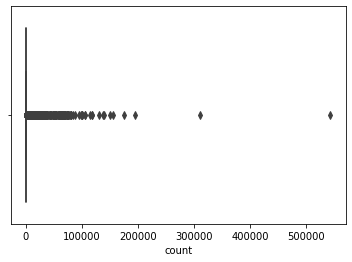

In [23]:
sns.boxplot(x=df_histogram['count'])

We can see on the graph that we have few outliers there. We might try to print out what are those words.

In [26]:
df_histogram[df_histogram['count'] > df_histogram['count'].quantile(.95)]

,lemma,count
0,wikipedii,4571
1,wikiprojekt,7065
2,wikipedie,114467
3,commons,9445
5,pictures,3372
...,...,...
1209026,''parazit,62
1239364,q54919,77
1244399,reisho,55
1244400,tokaido,168


Alright, we see there're such words as "wikipedie" or "wikipedii". We've been expecting that, because it's a czech equivalent for wikipedia - our source of data.

We might try to remove the outliers and keep the data in interquartile range.

In [27]:
y = df_histogram['count']
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))
df_histogram.drop(df_histogram[~removed_outliers].index, inplace=True)

Text(0.5, 0, 'Number of single lemma occurences')

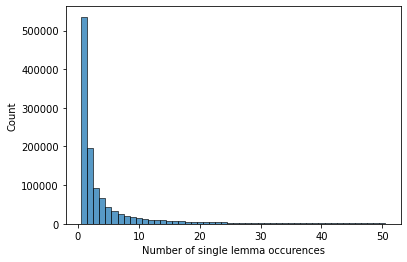

In [28]:
sns.histplot(data=df_histogram['count'],discrete=True)
plt.xlabel('Number of single lemma occurences')

<AxesSubplot:xlabel='count'>

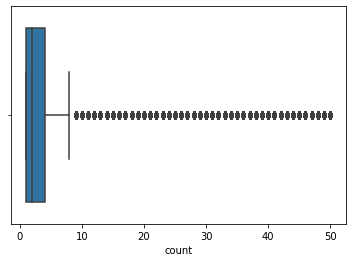

In [29]:
sns.boxplot(x=df_histogram['count'])

We might see that the're still more outliers, because our IQR has changed - but its normal because our data are not of non-normal distribution.